## Langgraph Project
**Hiring Recruiter Multi Agent Wrokflow**

In [1]:
# Install necessary libraries for LangChain and Langgraph.
# langchain: Core library for building LLM applications.
# langchain_core: Base abstractions for LangChain.
# langchain_community: Integrations with various third-party services.
# langgraph: Library for building stateful, multi-agent applications with LLMs.
!pip install langchain langchain_core langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
# Install the Google Generative AI library for LangChain.
!pip install langchain-google-genai

from langchain_google_genai import ChatGoogleGenerativeAI
import os

# Initialize the Google Gemini LLM.
# The `model` parameter specifies the Gemini model to use (e.g., "gemini-2.5-flash").
# The `google_api_key` parameter is used to authenticate with the Gemini API.
# In a production environment, it's recommended to store API keys securely, e.g., using environment variables.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key="api_key")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.1.1
    Uninstalling langchain-core-1.1.1:
      Successfully uninstalled langchain-core-1.1.1


In [5]:
import google.generativeai as genai

# Initialize the Generative Model directly using google.generativeai for simple interactions.
# This is separate from the LangChain LLM initialized above but uses the same API.
# generation_config sets parameters like temperature (creativity) and max_output_tokens.
model = genai.GenerativeModel(
    "gemini-2.5-flash",
    generation_config={
        "temperature": 0.5,
        "max_output_tokens": 1024,
    }
)

In [7]:
# Configure the generative AI client with your API key.
# This ensures that subsequent calls to `genai` functions are authenticated.
api_key = "api_key"
genai.configure(api_key=api_key)

In [8]:
# Send a test message to the configured Gemini model and print its response.
# This verifies that the API key and model initialization are working correctly.
response = model.generate_content("Hello, how are you?")
print(response.text)

Hello! I'm doing well, thank you for asking. I'm ready to assist you.

How can I help you today?


In [9]:
from typing_extensions import TypedDict

# Define the State for the Langgraph workflow.
# This TypedDict specifies the structure of the data that will be passed between nodes in the graph.
# - application: The raw job application text.
# - experience_level: Categorization of the candidate's experience (Entry-level, Mid-level, Senior-level).
# - skill_match: Indicates if the candidate's skills match the job description (Match/No Match).
# - response: The final outcome or message from the workflow.
class State(TypedDict):
  application: str
  experience_level: str
  skill_match : str
  response: str

In [20]:
from langgraph.graph import StateGraph, START, END

# Initialize a StateGraph with the defined State.
# StateGraph is a core component of Langgraph for building stateful agent workflows.
# START and END are special nodes representing the beginning and end of the graph.
workflow = StateGraph(State)

In [21]:
from langchain_core.prompts import ChatPromptTemplate

# Import ChatPromptTemplate for creating structured prompts for the LLM.
# This allows dynamic insertion of variables into a predefined prompt structure.

In [22]:
def categorize_experience(state: State) -> State:
  """
  Categorizes the experience level of a candidate based on their application.
  Uses an LLM to classify the experience as 'Entry-level', 'Mid-level', or 'Senior-level'.
  """
  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  """
  Assesses if a candidate's skills match the requirements for a Python Developer role.
  Uses an LLM to determine 'Match' or 'No Match' based on the application.
  """
  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:
  """
  Sets the response indicating that the candidate has been shortlisted for an HR interview.
  """
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  """
  Sets the response indicating that the candidate has senior-level experience but lacks specific job skills.
  This suggests a need for recruiter review.
  """
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  """
  Sets the response indicating that the candidate does not meet the job description and has been rejected.
  """
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [23]:
# Add each function as a node in the workflow graph.
# Each node represents a step or action in the application screening process.
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [24]:
def route_app(state: State) -> str:
  """
  Determines the next step in the workflow based on the candidate's skill match and experience level.
  - If skills match, schedule an HR interview.
  - If senior-level but no skill match, escalate to a recruiter.
  - Otherwise, reject the application.
  """
  if(state["skill_match"].strip().lower() == "match"):
    return "schedule_hr_interview"
  elif("senior-level" in state["experience_level"].strip().lower()):
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [25]:
# Define the edges (transitions) between nodes.
# - `add_edge` creates a direct, unconditional transition from one node to another.
# - `add_conditional_edges` creates transitions based on the output of a routing function (`route_app`).
#   The `route_app` function will determine the next node after 'assess_skillset'.
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

In [26]:
# Connect the START node to the initial step ('categorize_experience').
# Connect the final actions to the END node, marking the completion of the workflow path.
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

In [27]:
# Compile the workflow graph into an executable application.
# This step finalizes the graph structure, making it ready to be invoked.
app = workflow.compile()

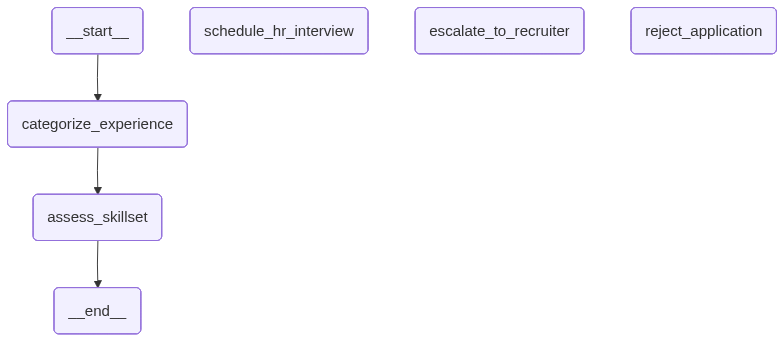

In [28]:
from IPython.display import Image, display

# Generate and display a visual representation of the compiled workflow graph.
# This helps in understanding the flow and logic of the multi-agent system.
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [29]:
def run_candidate_screening(application: str):
  """
  Executes the candidate screening workflow for a given job application.
  Invokes the compiled Langgraph application and returns the key results.
  """
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [30]:
# Test the screening workflow with an application for a Java developer.
# Expected outcome: Senior-level experience, No Match for Python, rejected.
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on 10 years of experience in software engineering, the candidate should be categorized as **Senior-level**.

**Reasoning:**
*   **Entry-level** typically has 0-2 years of experience.
*   **Mid-level** typically has 3-7 years of experience.
*   **Senior-level** typically has 8+ years of experience, often indicating deep expertise, leadership potential, and the ability to work on complex architectural challenges.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: Based on 10 years of experience in software engineering, the candidate should be categorized as **Senior-level**.

**Reasoning:**
*   **Entry-level** typically has 0-2 years of experience.
*   **Mid-level** typically has 3-7 years of experience.
*   **Senior-level** typically has 8+ years of 

In [31]:
# Test the screening workflow with a vague application that mentions Python.
# Expected outcome: Ambiguous experience, No Match for specific skills, rejected.
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based *solely* on the information provided, it is **impossible to definitively categorize** the candidate as Entry-level, Mid-level, or Senior-level.

Here's why:

*   **"Experience in software engineering"**: This is too vague. It could mean 6 months of internship experience, or 15 years of industry experience. Both count as "experience."
*   **"Expertise in Python"**: Similarly, this is subjective. An entry-level developer might feel they have "expertise" after successfully completing several complex projects, while a senior architect's "expertise" would involve deep understanding of Python internals, performance optimization, and framework design.

To categorize accurately, more information would be needed, such as:
*   **Years of experience**
*   **Types of projects/responsibilities**
*   **Leadership or mentoring roles**
*   **Specific achievements or contributions**

Assessing the skillset of candidate : 
Skill

In [32]:
# Test the screening workflow with a strong application for a Python backend developer.
# Expected outcome: Mid-level experience, Match for Python, scheduled for HR interview.
application_text = "I have 5 experience as a Python backend developer"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on 5 years of experience as a Python backend developer, the candidate would be categorized as **Mid-level**.

**Reasoning:**

*   **Entry-level** is typically 0-2 years of experience.
*   **Mid-level** is generally considered 2-5 years of solid professional experience. Candidates at this level can work independently, solve complex problems, and contribute significantly.
*   **Senior-level** usually requires 5+ (often 7+) years of experience, often with a proven track record of leadership, architectural contributions, and mentoring junior staff. While 5 years *could* be considered senior in some very fast-paced or smaller companies, it generally sits at the higher end of mid-level, or a "junior senior" if a company has multiple senior tiers. Without more context, mid-level is the most appropriate general categorization.

Assessing the skillset of candidate : 
Skill Match : Match

Scheduling the interview : 


Co